# Imports:

In [3]:
from collections import Counter
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score, f1_score
from sklearn.svm import OneClassSVM
import joblib
from skimage.feature import hog
from skimage.feature import local_binary_pattern
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pickle
import os

In [4]:
cam17_dataset = load_dataset("jxie/camelyon17")

#### Analysis of the statistical characteristics describing the data:

In [5]:
print(cam17_dataset)

DatasetDict({
    id_train: Dataset({
        features: ['image', 'label'],
        num_rows: 302436
    })
    id_val: Dataset({
        features: ['image', 'label'],
        num_rows: 33560
    })
    ood_test: Dataset({
        features: ['image', 'label'],
        num_rows: 85054
    })
    ood_val: Dataset({
        features: ['image', 'label'],
        num_rows: 34904
    })
    unlabeled_train: Dataset({
        features: ['image', 'label'],
        num_rows: 600030
    })
})


In [6]:
print(cam17_dataset["id_train"].features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['0', '1'], id=None)}


#### The dataset consists of multiple splits: id_train, id_val, ood_test, ood_val, unlabeled_train. Each split contains images and their labels [0 = Normal, 1 = Tumor].

In [7]:
def count_labels(dataset):
    labels = [example["label"] for example in dataset]
    return Counter(labels)

for split in cam17_dataset.keys():
    label_counts = count_labels(cam17_dataset[split])
    print(f"{split}: {label_counts}")

id_train: Counter({1: 151390, 0: 151046})
id_val: Counter({0: 16952, 1: 16608})
ood_test: Counter({0: 42527, 1: 42527})
ood_val: Counter({0: 17452, 1: 17452})
unlabeled_train: Counter({0: 600029, 1: 1})


#### The dataset is very balanced, with as much normal samples as tumor samples in every split, except the unlabeled_train split, which is used for Self-Supervised or semi-supervised learning. We don't need techniques like class weighting or resampling.

In [8]:
for split in cam17_dataset.keys():
    first_image = cam17_dataset[split][0]["image"]
    print(f"{split}: {first_image.size}")

id_train: (96, 96)
id_val: (96, 96)
ood_test: (96, 96)
ood_val: (96, 96)
unlabeled_train: (96, 96)


#### All images have the same size, so we can use fixed input dimensions for our model. If images have had different sizes, we might have needed to resize them before training.

In [9]:
for split in cam17_dataset.keys():
    print(f"{split} contains {len(cam17_dataset[split])} samples.")

id_train contains 302436 samples.
id_val contains 33560 samples.
ood_test contains 85054 samples.
ood_val contains 34904 samples.
unlabeled_train contains 600030 samples.


#### The ood_test set allows us to evaluate the model's generalization ability. We have 85,5054 samples, which is enough.

In [10]:
def analyze_pixel_distribution(dataset, sample_size=500):
    pixel_values = []

    for i in range(min(sample_size, len(dataset))):
        img = np.array(dataset[i]["image"])
        pixel_values.extend(img.flatten()) # 1D

    pixel_values = np.array(pixel_values)
    print(f"Mean: {np.mean(pixel_values)}, Std: {np.std(pixel_values)}")
    print(f"Min: {np.min(pixel_values)}, Max: {np.max(pixel_values)}")

analyze_pixel_distribution(cam17_dataset["id_train"])

Mean: 174.53578544560185, Std: 60.402813368051994
Min: 0, Max: 255


####  Since the pixel range is 0 to 255, we must normalize images before training our models.

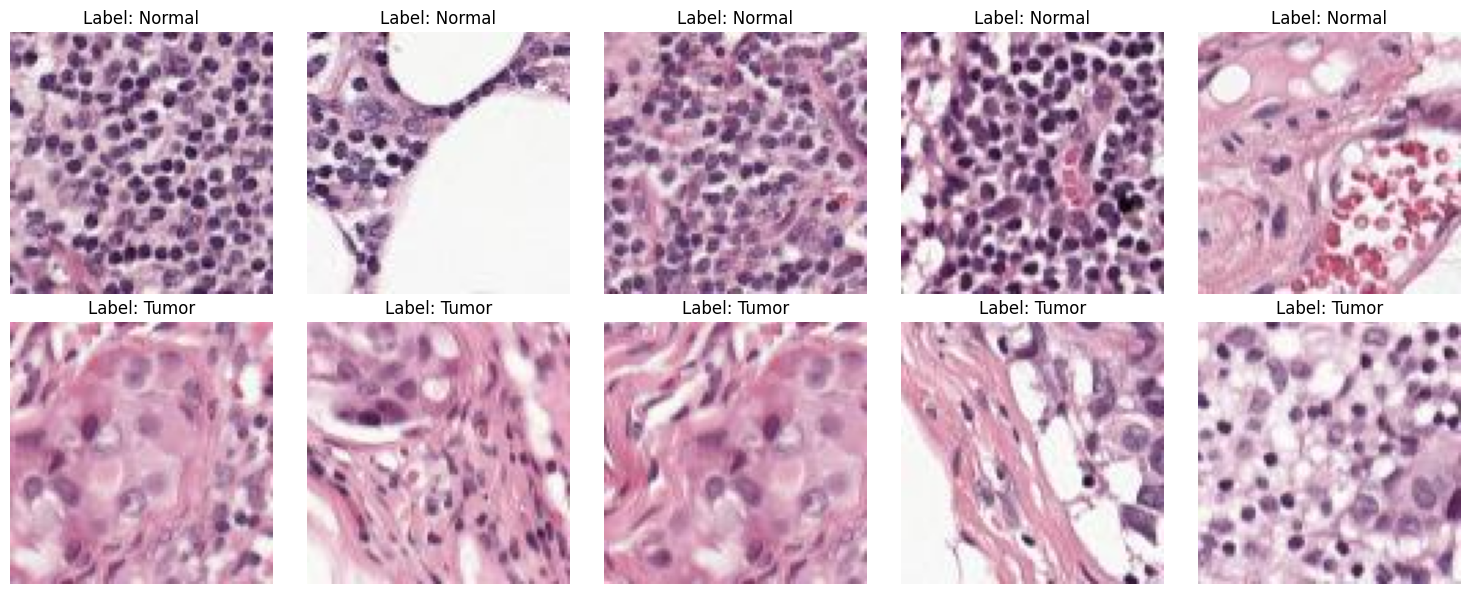

In [11]:
normal_samples = [sample for sample in cam17_dataset["id_train"] if sample["label"] == 0][:5]
tumor_samples = [sample for sample in cam17_dataset["id_train"] if sample["label"] == 1][:5]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot normal samples
for i, sample in enumerate(normal_samples):
    axes[0, i].imshow(sample["image"])
    axes[0, i].set_title("Label: Normal")
    axes[0, i].axis("off")

# Plot tumor samples
for i, sample in enumerate(tumor_samples):
    axes[1, i].imshow(sample["image"])
    axes[1, i].set_title("Label: Tumor")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Some tumor samples might be difficult to distinguish visually, requiring deep learning models for accurate classification. That's when I come in to built such models in my project.

#### Checking for missing values

In [12]:
def check_missing_values(dataset):
    missing_images = 0
    missing_labels = 0

    for curr_example in dataset:
        if curr_example["image"] is None:
            missing_images += 1
        if curr_example["label"] is None:
            missing_labels += 1

    return missing_images, missing_labels

for split in cam17_dataset.keys():
    img_missing, label_missing = check_missing_values(cam17_dataset[split])
    print(f"{split}: {img_missing} missing images, {label_missing} missing labels")

id_train: 0 missing images, 0 missing labels
id_val: 0 missing images, 0 missing labels
ood_test: 0 missing images, 0 missing labels
ood_val: 0 missing images, 0 missing labels
unlabeled_train: 0 missing images, 0 missing labels


#### No missing values found in our dataset. Perfect!

#### Checking for extreme values, which can occur in pixel intensity distributions or labels.

In [13]:
def check_pixel_extremes(dataset, sample_size=500):
    min_pixel, max_pixel = 255, 0

    for i in range(min(sample_size, len(dataset))):
        img = np.array(dataset[i]["image"])
        min_pixel = min(min_pixel, np.min(img))
        max_pixel = max(max_pixel, np.max(img))

    print(f"Pixel Intensity Range: Min={min_pixel}, Max={max_pixel}")

check_pixel_extremes(cam17_dataset["id_train"])

Pixel Intensity Range: Min=0, Max=255


#### The dataset has expected pixel values, and no extreme values exist.

#### Data Dependency Analysis with Visualizations

In [14]:
id_train_df = pd.DataFrame(cam17_dataset["id_train"])
id_val_df = pd.DataFrame(cam17_dataset["id_val"])
ood_test_df = pd.DataFrame(cam17_dataset["ood_test"])
ood_val_df = pd.DataFrame(cam17_dataset["ood_val"])

id_train_df["dataset"] = "id_train"
id_val_df["dataset"] = "id_val"
ood_test_df["dataset"] = "ood_test"
ood_val_df["dataset"] = "ood_val"

df = pd.concat([id_train_df, id_val_df, ood_test_df, ood_val_df], ignore_index=True)

In [15]:
df.head()

,image,label,dataset
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,id_train
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,id_train
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,id_train
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,id_train
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,id_train


#### Now we have a structured DataFrame for visualization.

### Class Distribution Across Splits:

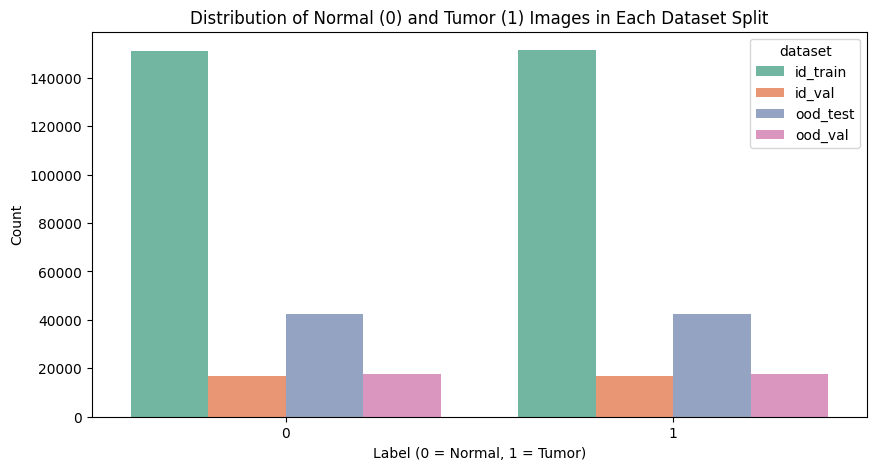

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="label", hue="dataset", palette="Set2")
plt.title("Distribution of Normal (0) and Tumor (1) Images in Each Dataset Split")
plt.xlabel("Label (0 = Normal, 1 = Tumor)")
plt.ylabel("Count")
plt.show()

#### The dataset sure is balanced, meaning we do not need class balancing techniques. Both in-distribution and out-of-distribution datasets have similar class distributions.

### Image Size Distribution:

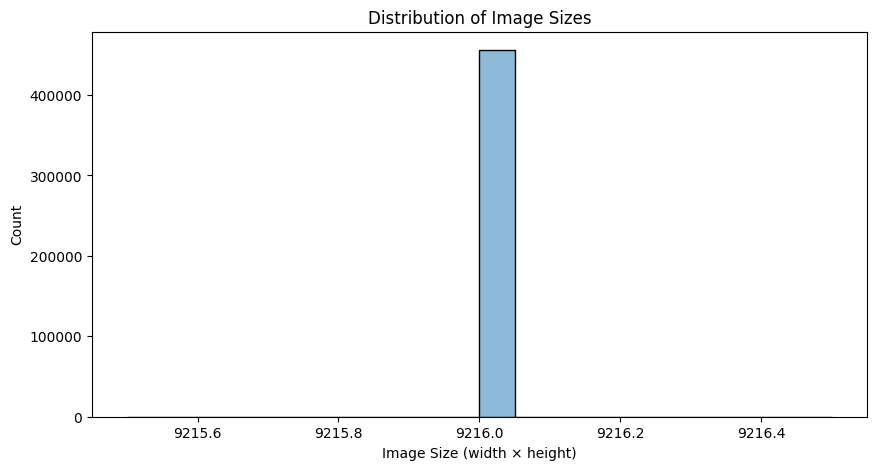

In [17]:
df["image_width"] = df["image"].apply(lambda x: x.size[0])
df["image_height"] = df["image"].apply(lambda x: x.size[1])
df["image_size"] = df["image_width"] * df["image_height"]

plt.figure(figsize=(10, 5))
sns.histplot(df["image_size"], bins=20, kde=True)

plt.title("Distribution of Image Sizes")
plt.xlabel("Image Size (width × height)")
plt.ylabel("Count")
plt.show()

#### All images have similar sizes, suggesting no need for resizing. If we had extreme variations, we would need resizing preprocessing.

### Average Pixel Intensity Per Image:

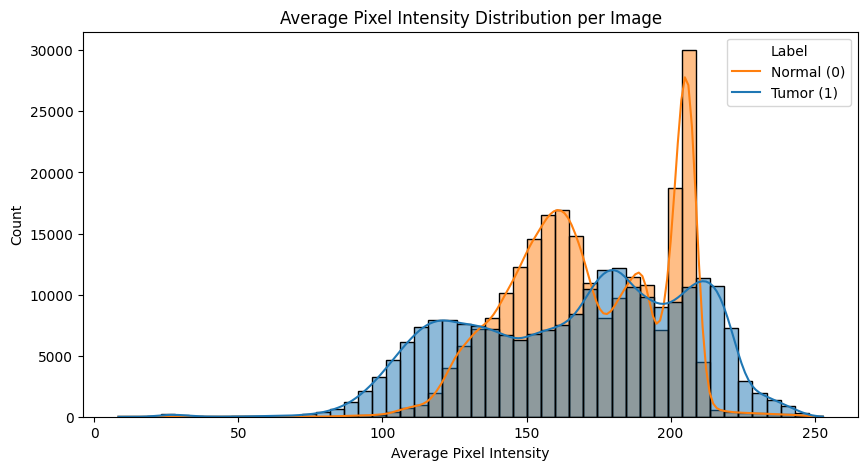

In [49]:
df["label"] = df["label"].astype(str)
df["avg_pixel_intensity"] = df["image"].apply(lambda x: np.mean(np.array(x)))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x="avg_pixel_intensity", hue="label", bins=50, kde=True)

plt.title("Average Pixel Intensity Distribution per Image")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Count")
plt.legend(title="Label", labels=["Normal (0)", "Tumor (1)"])
plt.show()

df["label"] = df["label"].astype(int)

#### Normal images have higher brightness than tumor images. Tumor images tend to have darker regions, suggesting histological differences.

### Boxplot of Pixel Intensities by Class

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\986941485.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="avg_pixel_intensity", palette="muted")


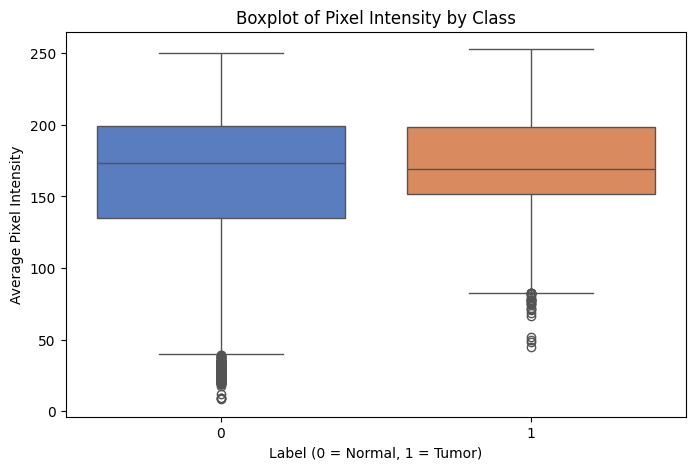

In [50]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="label", y="avg_pixel_intensity", palette="muted")
plt.title("Boxplot of Pixel Intensity by Class")
plt.xlabel("Label (0 = Normal, 1 = Tumor)")
plt.ylabel("Average Pixel Intensity")
plt.show()

#### The median intensity for tumor images is lower, confirming darker tumor regions. Some tumor images have outliers, which might be artifacts in slides

### Pixel Intensity Distribution for Each Dataset Split

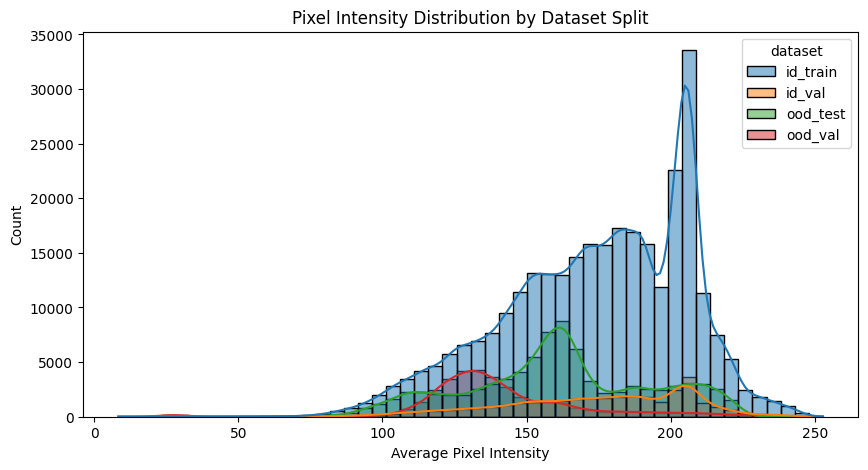

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="avg_pixel_intensity", hue="dataset", bins=50, kde=True)
plt.title("Pixel Intensity Distribution by Dataset Split")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Count")
plt.show()

#### The intesity distribution looking at each split varies. The training dataset shows a lot more pixel intensity and the OOD dataset has a slightly different intensity distribution, suggesting domain shift. This means our model must generalize well to handle distribution changes.

### Color Channel Distribution

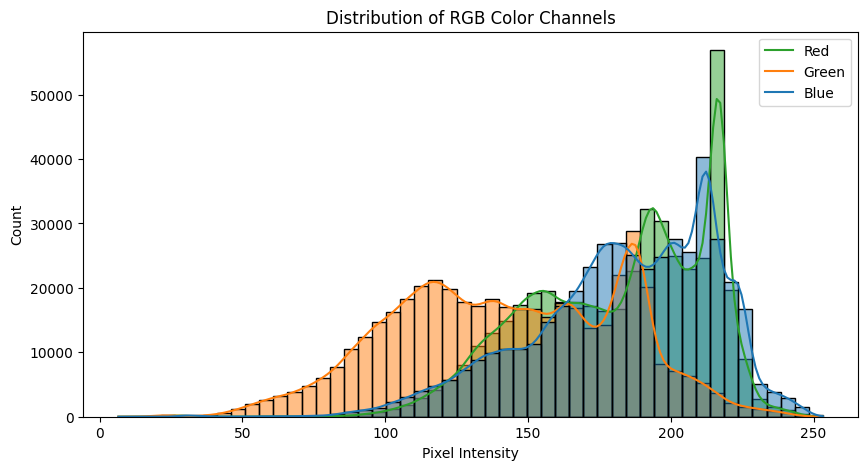

In [24]:
def extract_channel_means(image):
    img = np.array(image)
    return np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])

df["R"], df["G"], df["B"] = zip(*df["image"].apply(extract_channel_means))

plt.figure(figsize=(10,5))
sns.histplot(df[["R", "G", "B"]], bins=50, kde=True)
plt.title("Distribution of RGB Color Channels")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.legend(["Red", "Green", "Blue"])
plt.show()

#### Models should be color-invariant, so data augmentation like color jittering might help.

### Tumor vs. Normal Pixel Intensity per RGB Channel

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\2213363315.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="R", palette="Reds")


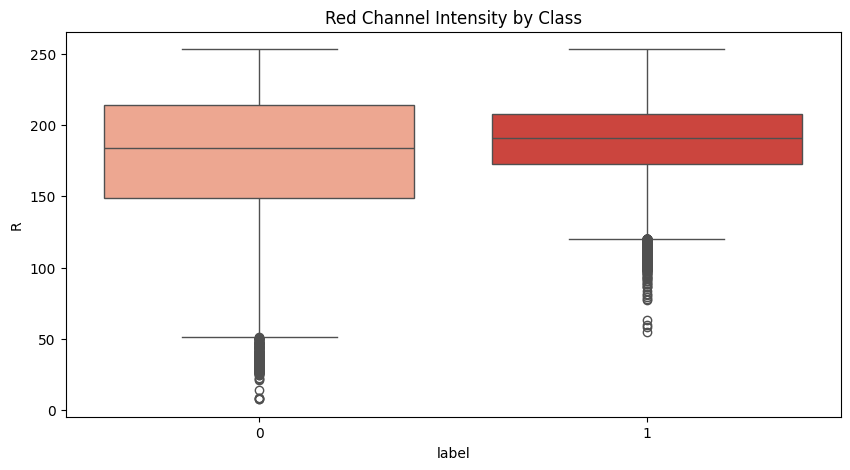

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\2213363315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="G", palette="Greens")


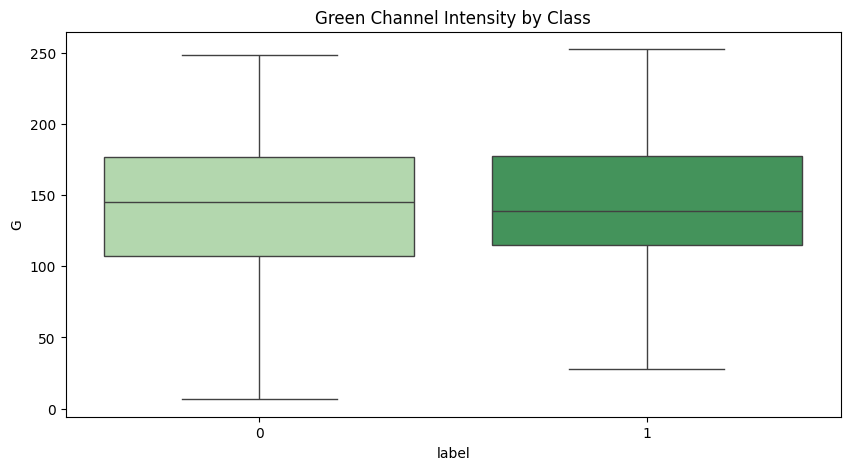

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\2213363315.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="B", palette="Blues")


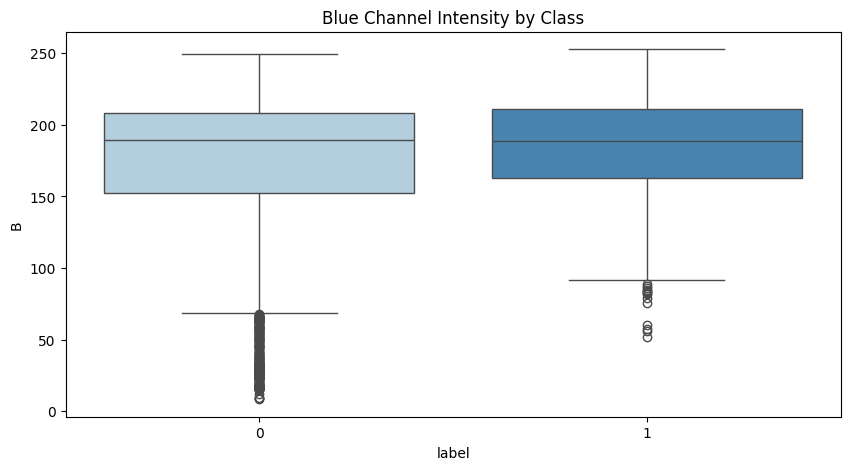

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="label", y="R", palette="Reds")
plt.title("Red Channel Intensity by Class")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="label", y="G", palette="Greens")
plt.title("Green Channel Intensity by Class")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="label", y="B", palette="Blues")
plt.title("Blue Channel Intensity by Class")
plt.show()

#### Tumor images have lower red channel values, the blue channel seems almost the same when normal and when there's a tumor.

### Correlation Matrix of Image Features

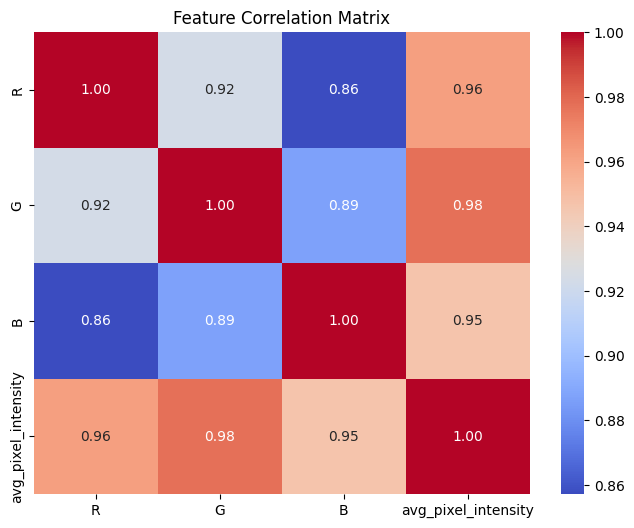

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["R", "G", "B", "avg_pixel_intensity"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

#### The RGB channels are strongly correlated, meaning we can use grayscale conversion to reduce complexity.

### Histogram of Pixel Intensities Separately for ID and OOD Datasets

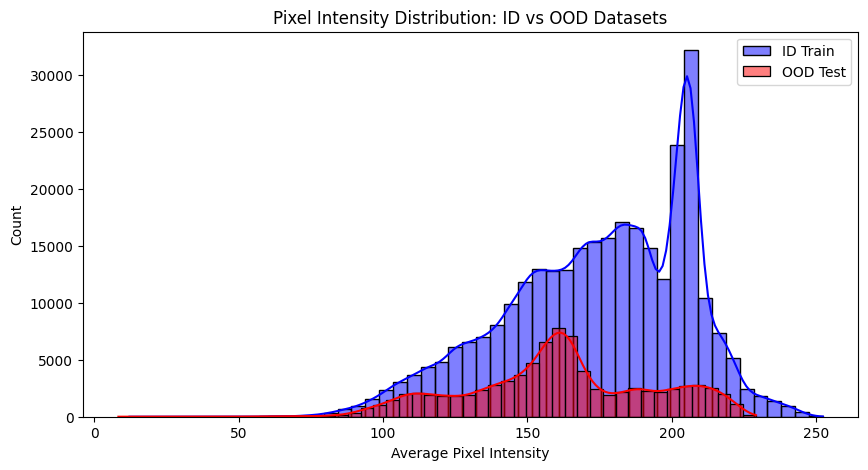

In [27]:
plt.figure(figsize=(10,5))

sns.histplot(df[df["dataset"] == "id_train"]["avg_pixel_intensity"], bins=50, kde=True, color="blue", label="ID Train")
sns.histplot(df[df["dataset"] == "ood_test"]["avg_pixel_intensity"], bins=50, kde=True, color="red", label="OOD Test")

plt.title("Pixel Intensity Distribution: ID vs OOD Datasets")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Helps compare pixel intensity distributions between in-distribution and out-of-distribution datasets. The distributions differ significantly, the model might struggle to generalize to OOD data

### Scatter Plot of Red vs. Green Channel Intensities

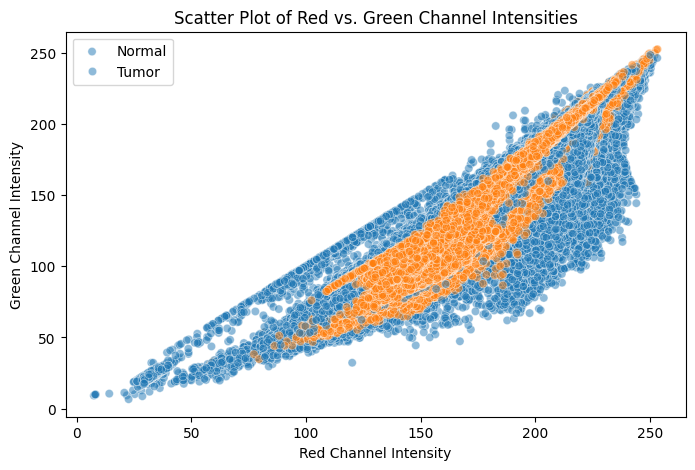

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="R", y="G", hue="label", alpha=0.5)
plt.title("Scatter Plot of Red vs. Green Channel Intensities")
plt.xlabel("Red Channel Intensity")
plt.ylabel("Green Channel Intensity")
plt.legend(["Normal", "Tumor"])
plt.show()

#### Visualizes color relationships in images

### Stacked Bar Chart of Class Distribution per Dataset Split

<Figure size 800x500 with 0 Axes>

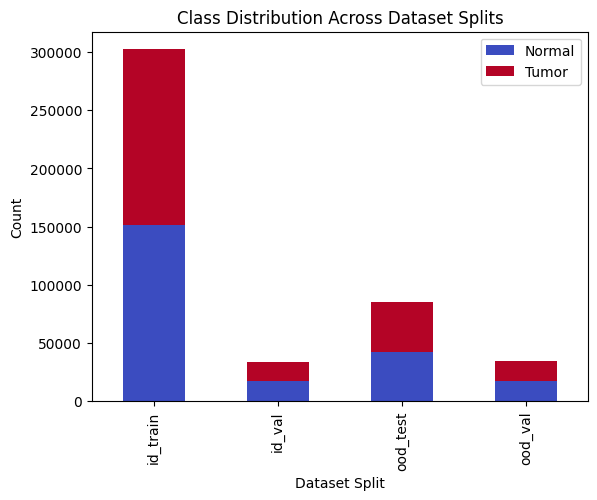

In [29]:
plt.figure(figsize=(8,5))
df.groupby(["dataset", "label"]).size().unstack().plot(kind="bar", stacked=True, colormap="coolwarm")
plt.title("Class Distribution Across Dataset Splits")
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.legend(["Normal", "Tumor"])
plt.show()

#### Further prove that we don't need class balancing. If any dataset split is highly imbalanced, we might have needed to re-balance it.

### Scatter Plot of Image Width vs. Height

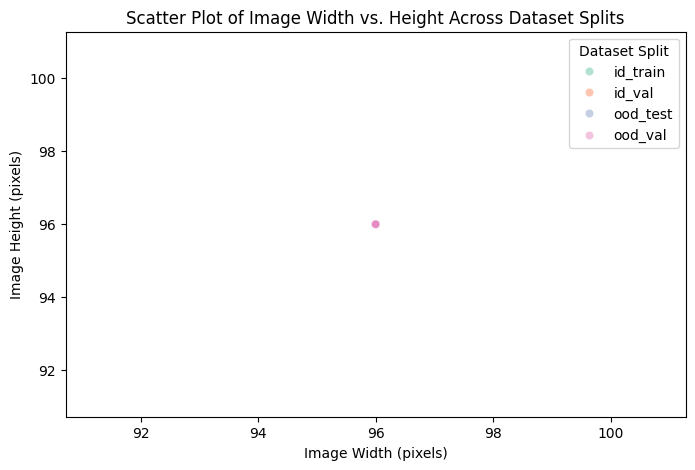

In [30]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="image_width", y="image_height", hue="dataset", alpha=0.5, palette="Set2")
plt.title("Scatter Plot of Image Width vs. Height Across Dataset Splits")
plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
plt.legend(title="Dataset Split")
plt.show()

#### Perfect correlation between width and height for each dataset split.

### Violin Plot of Green Channel Intensity by Class

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\1988687151.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="label", y="G", palette="Greens")


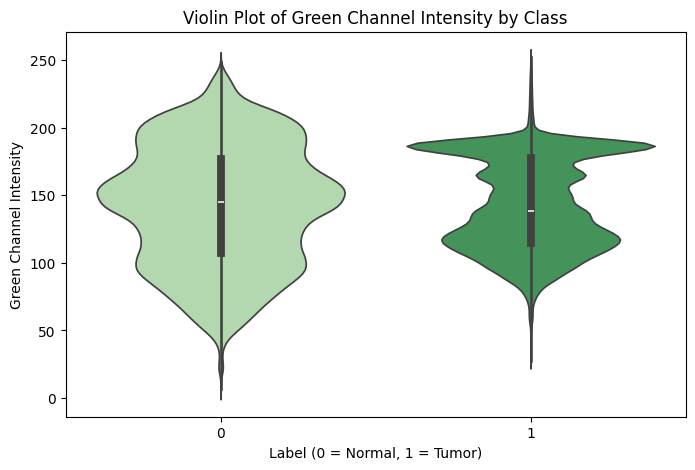

In [31]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x="label", y="G", palette="Greens")
plt.title("Violin Plot of Green Channel Intensity by Class")
plt.xlabel("Label (0 = Normal, 1 = Tumor)")
plt.ylabel("Green Channel Intensity")
plt.show()

#### Useful for choosing color-based preprocessing techniques later

### PCA Visualization of Images in 2D Feature Space

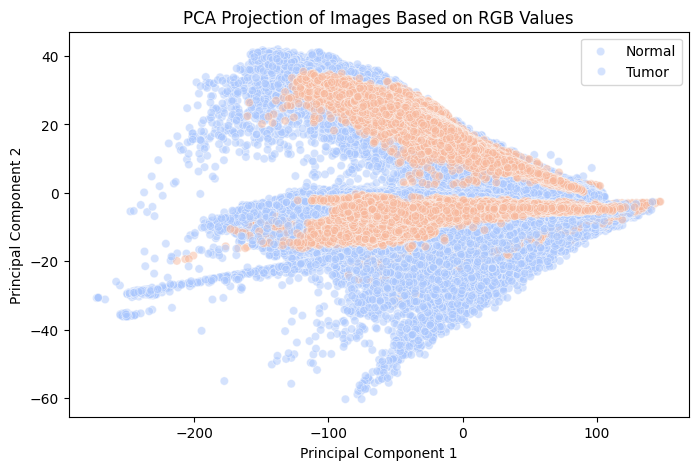

In [32]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[["R", "G", "B"]])

plt.figure(figsize=(8,5))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df["label"], palette="coolwarm", alpha=0.5)
plt.title("PCA Projection of Images Based on RGB Values")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(["Normal", "Tumor"])
plt.show()

#### Visualizes separability of tumor vs. normal images in feature space, which helps determine whether feature extraction is effective. PCA compressed the RGB color space from 3D to 2D while preserving variance

### Heatmap of Class Distribution Over Dataset Splits

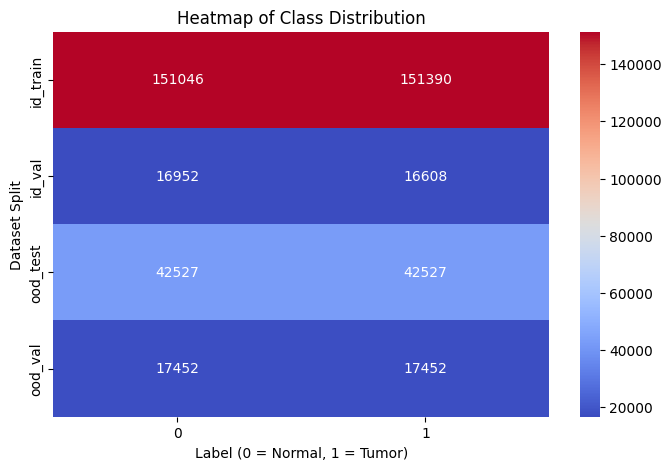

In [33]:
plt.figure(figsize=(8,5))
sns.heatmap(df.pivot_table(index="dataset", columns="label", aggfunc="size"), annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Class Distribution")
plt.xlabel("Label (0 = Normal, 1 = Tumor)")
plt.ylabel("Dataset Split")
plt.show()

#### Dataset doesn't need resampling

### Comparison of Pixel Intensity Distributions Before and After Normalization

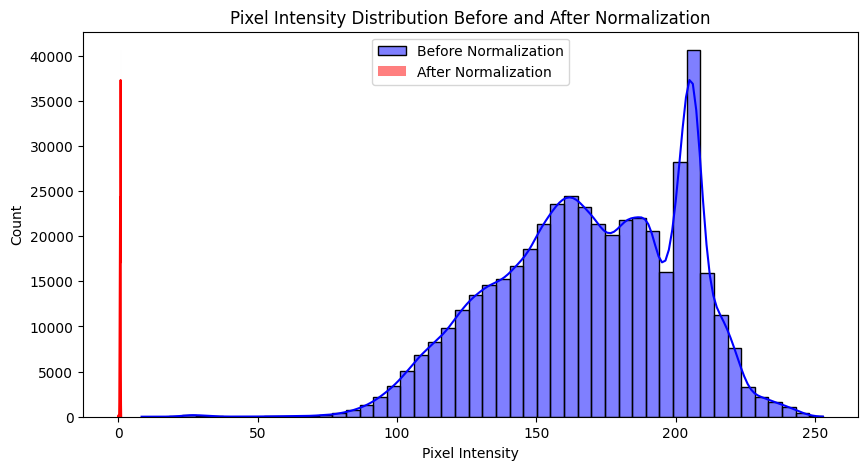

In [34]:
df["normalized_pixel_intensity"] = (df["avg_pixel_intensity"] - df["avg_pixel_intensity"].min()) / (df["avg_pixel_intensity"].max() - df["avg_pixel_intensity"].min())

plt.figure(figsize=(10,5))
sns.histplot(df["avg_pixel_intensity"], bins=50, kde=True, color="blue", label="Before Normalization")
sns.histplot(df["normalized_pixel_intensity"], bins=50, kde=True, color="red", label="After Normalization")
plt.title("Pixel Intensity Distribution Before and After Normalization")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Ensures pixel values are scaled properly before CNN training

### Class Distribution for OOD Validation Set

C:\Users\stefa\AppData\Local\Temp\ipykernel_14316\3403903450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df["dataset"] == "ood_val"], x="label", palette="pastel")


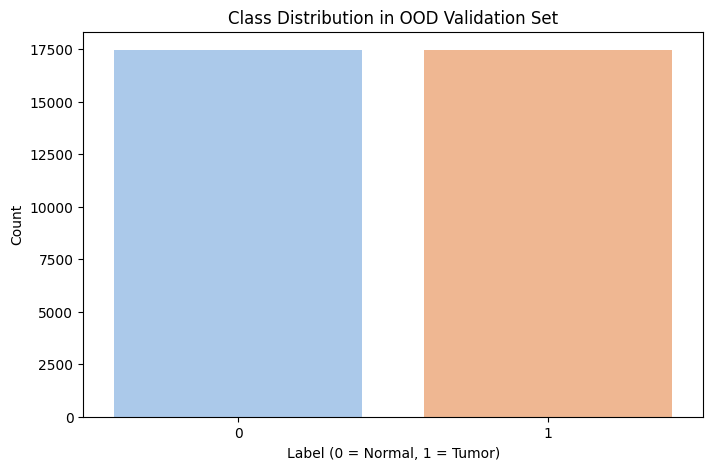

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(data=df[df["dataset"] == "ood_val"], x="label", palette="pastel")
plt.title("Class Distribution in OOD Validation Set")
plt.xlabel("Label (0 = Normal, 1 = Tumor)")
plt.ylabel("Count")
plt.show()

#### To be sure once again. Ensures proper class representation in OOD validation

### Histogram of Aspect Ratios

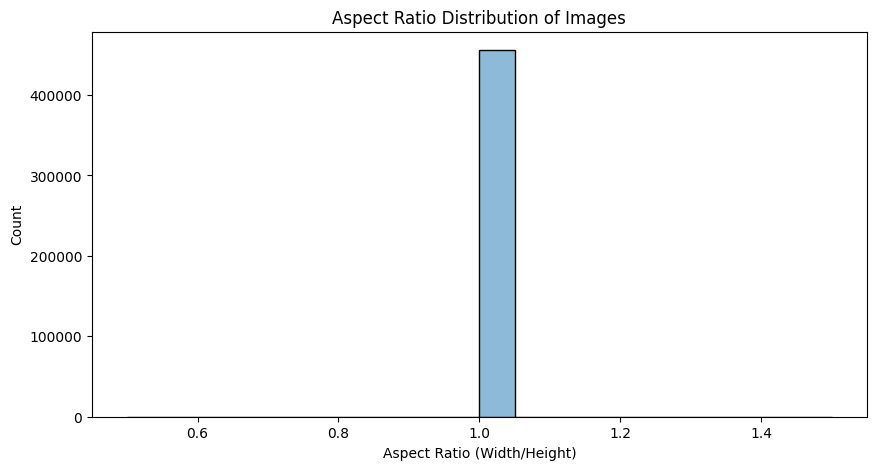

In [36]:
df["aspect_ratio"] = df["image_width"] / df["image_height"]

plt.figure(figsize=(10,5))
sns.histplot(df["aspect_ratio"], bins=20, kde=True)
plt.title("Aspect Ratio Distribution of Images")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Count")
plt.show()

#### Helps decide if we need to resize images uniformly. If aspect ratios vary significantly, maintaining aspect ratio in resizing is important, but that isn't the case here.

### Experimenting with Dimensionality Reduction Algorithms

#### We will try to reduce the RGB features of images while preserving variance using t-SNE.

In [37]:
df_sampled = df.sample(n=10000, random_state=42)

In [38]:
rgb_features = df_sampled[["R", "G", "B"]].values  # Reduce dataset size

# Apply PCA to reduce from 3D (RGB) to 50D
pca = PCA(n_components=3)  # Reduce to 3D
pca_features = pca.fit_transform(rgb_features)

# Apply t-SNE to reduced features
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)  # Reduce iterations
tsne_features = tsne.fit_transform(pca_features)

# Store results
df_sampled["tsne_feature_1"] = tsne_features[:, 0]
df_sampled["tsne_feature_2"] = tsne_features[:, 1]

c:\Users\stefa\Desktop\FMI\ML-Jupyter Notebook\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


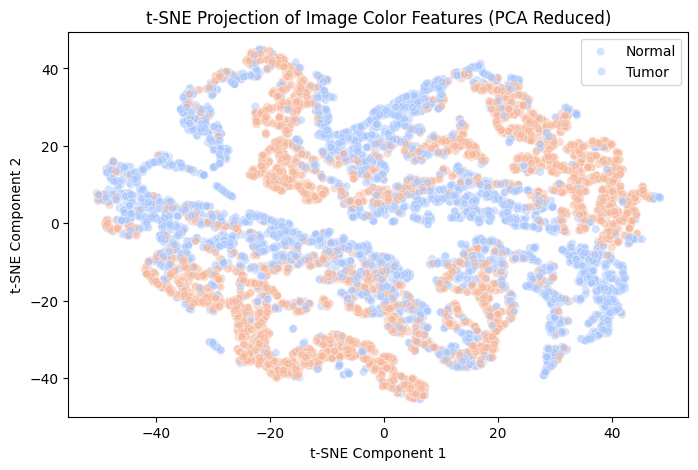

In [39]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_sampled, x="tsne_feature_1", y="tsne_feature_2", hue="label", alpha=0.5, palette="coolwarm")
plt.title("t-SNE Projection of Image Color Features (PCA Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(["Normal", "Tumor"])
plt.show()

#### t-SNE successfully reduced the dataset to a 2D feature space after applying PCA for initial dimensionality reduction. The scatter plot shows clustering patterns between normal and tumor images.

### We will do the PCA again to store reduced features in the dataset. (From 3D to 2D)

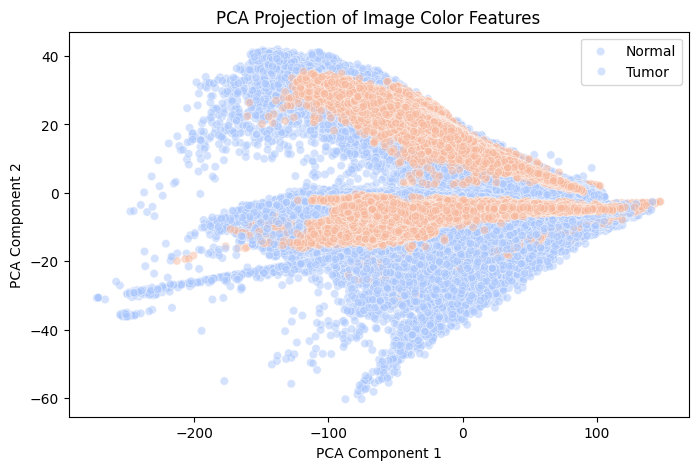

In [40]:
rgb_features = df[["R", "G", "B"]].values  # Extract color features

# Apply PCA to reduce 3D RGB features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(rgb_features)

# Store reduced features in the dataset
df["pca_feature_1"] = reduced_features[:, 0]
df["pca_feature_2"] = reduced_features[:, 1]

# Scatter plot of reduced features
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="pca_feature_1", y="pca_feature_2", hue="label", alpha=0.5, palette="coolwarm")
plt.title("PCA Projection of Image Color Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(["Normal", "Tumor"])
plt.show()

#### PCA compressed the RGB color space from 3D to 2D while preserving variance

## Prepare Data

In [52]:
df_train = df[df["dataset"] == "id_train"]
df_test = df[df["dataset"] == "id_val"]

df_train_sampled = df_train.sample(n=40000, random_state=42)

X_train_sampled = df_train_sampled["image"].tolist()
y_train_sampled = df_train_sampled["label"].values

X_test = df_test["image"].tolist()
y_test = df_test["label"].values

print(f"Training Samples: {len(X_train_sampled)}, Testing Samples: {len(X_test)}")

Training Samples: 40000, Testing Samples: 33560


### Extracting features using a pretrained resnet model

In [53]:
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def extract_features(image):
    img_tensor = transform(image).unsqueeze(0) # batch dimension
    with torch.no_grad():
        features = resnet(img_tensor)
    return features.squeeze().numpy()

X_train_features = np.array([extract_features(img) for img in X_train_sampled])
X_test_features = np.array([extract_features(img) for img in X_test])

y_train = np.array(y_train_sampled)
y_test = np.array(y_test)

print(f"Feature Shape: {X_train_features.shape}")

c:\Users\stefa\Desktop\FMI\ML-Jupyter Notebook\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stefa\Desktop\FMI\ML-Jupyter Notebook\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature Shape: (40000, 512)


### Experiment 1: Isolation Forest

In [54]:
def kappa_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    y_pred = np.where(y_pred == -1, 1, 0)  # Convert (-1 anomaly to 1 tumor, 1 normal to 0)
    return cohen_kappa_score(y_true, y_pred)

custom_scorer = make_scorer(kappa_scorer, greater_is_better=True)

param_grid_iso = {
    "n_estimators": [50, 100, 200],
    "contamination": [0.1, 0.2, 0.3, 0.4, 'auto'],
    "max_samples": ["auto", 0.8, 0.9]
}

In [55]:
grid_iso = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid_iso,
    scoring=custom_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_iso.fit(X_train_features, y_train)

best_iso_model = grid_iso.best_estimator_

print(f"Best Isolation Forest Parameters: {grid_iso.best_params_}")

Fitting 3 folds for each of 45 candidates, totalling 135 fits


c:\Users\stefa\Desktop\FMI\ML-Jupyter Notebook\venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Isolation Forest Parameters: {'contamination': 0.1, 'max_samples': 'auto', 'n_estimators': 50}


In [56]:
y_pred_iso_best = best_iso_model.predict(X_test_features)
y_pred_iso_best = np.where(y_pred_iso_best == -1, 1, 0)

kappa_iso_best = cohen_kappa_score(y_test, y_pred_iso_best)
f1_iso_best = f1_score(y_test, y_pred_iso_best)

print(f"Best Isolation Forest - Cohen's Kappa: {kappa_iso_best}, F1-score: {f1_iso_best}")

Best Isolation Forest - Cohen's Kappa: -0.04212696619585321, F1-score: 0.13727928376025864


#### We got very bad results, because we only used a small sample.

### Experiment 2: OneClassSVM

In [46]:
param_grid_svm = {
    "nu": [0.3, 0.4],
}


grid_svm = GridSearchCV(
    OneClassSVM(),
    param_grid_svm,
    scoring=custom_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_svm.fit(X_train_features, y_train)

best_svm_model = grid_svm.best_estimator_

print(f"Best One-Class SVM Parameters: {grid_svm.best_params_}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\stefa\Desktop\FMI\ML-Jupyter Notebook\venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Best One-Class SVM Parameters: {'nu': 0.3}


In [47]:
oc_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma="scale")
oc_svm.fit(X_train_features)

OneClassSVM(nu=0.1)

In [57]:
y_pred_svm_best = best_svm_model.predict(X_test_features)
y_pred_svm_best = np.where(y_pred_svm_best == -1, 1, 0)

kappa_svm_best = cohen_kappa_score(y_test, y_pred_svm_best)
f1_svm_best = f1_score(y_test, y_pred_svm_best)

print(f"Best One-Class SVM - Cohen's Kappa: {kappa_svm_best}, F1-score: {f1_svm_best}")

Best One-Class SVM - Cohen's Kappa: -0.1296454160314442, F1-score: 0.2974099434355463


#### We can see that the Isolation Forest gives a bit better results. Let's save the models.

In [58]:
joblib.dump(best_iso_model, "best_isolation_forest.pkl")
#joblib.dump(best_svm_model, "best_one_class_svm.pkl")

['best_isolation_forest.pkl']

### Now we will compare the Isolation Forest with a CNN.

In [59]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [60]:
class Camelyon17Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.images = dataframe["image"].tolist()
        self.labels = dataframe["label"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

train_dataset = Camelyon17Dataset(df_train.sample(n=40000, random_state=42), transform=transform_train)
test_dataset = Camelyon17Dataset(df_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

Training samples: 40000, Testing samples: 33560


In [61]:
class TumorCNN(nn.Module):
    def __init__(self):
        super(TumorCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(0.5) # prevent overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

cnn_model = TumorCNN()

### Training the model

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001)

num_epochs = 3 

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/3, Loss: 0.3721528884410858
Epoch 2/3, Loss: 0.22488603524565698
Epoch 3/3, Loss: 0.18471610260009766


### Evaluate the model

In [63]:
cnn_model.eval()
y_pred_cnn = []
y_true_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        y_pred_cnn.extend(predicted.cpu().numpy())
        y_true_cnn.extend(labels.cpu().numpy())

kappa_cnn = cohen_kappa_score(y_true_cnn, y_pred_cnn)
print(f"Custom CNN - Cohen's Kappa: {kappa_cnn}")

Custom CNN - Cohen's Kappa: 0.8693866404668169


#### The Custom CNN we built gave way better cohen's kappa score. For now this is the model we want to use.

### Let's compare the CNN with U-net autoencoder.

In [64]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()
        
        self.enc1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.dec3 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.dec1 = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(x1))
        x3 = F.relu(self.enc3(x2))
        
        x = F.relu(self.dec3(x3))
        x = F.relu(self.dec2(x + x2))
        x = torch.sigmoid(self.dec1(x + x1))

        return x

unet_model = UNetAutoencoder()

#### Train the U-net

In [65]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(unet_model.parameters(), lr=0.001)

num_epochs = 3

train_normal_dataset = df_train[df_train["label"] == 0].sample(n=1000, random_state=42)
train_loader = DataLoader(Camelyon17Dataset(train_normal_dataset, transform=transform_train), batch_size=64, shuffle=True)

for epoch in range(num_epochs):
    unet_model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = unet_model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/3, Loss: 0.15852279867976904
Epoch 2/3, Loss: 0.10246355179697275
Epoch 3/3, Loss: 0.09364784369245172


### Evaluate

In [66]:
unet_model.eval()
reconstruction_errors = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = unet_model(images)

        errors = torch.mean((images - outputs) ** 2, dim=[1, 2, 3])
        reconstruction_errors.extend(errors.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_unet = (reconstruction_errors > threshold).astype(int)

kappa_unet = cohen_kappa_score(y_test, y_pred_unet)
print(f"U-Net Autoencoder - Cohen's Kappa: {kappa_unet}")

U-Net Autoencoder - Cohen's Kappa: -0.08534032673291136


#### The best model for us to use is the Custom CNN we did. (Because I tested it on a large sample and it provides better results)

In [67]:
os.makedirs("model_artifact", exist_ok=True)

model_path = os.path.join("model_artifact", "cnn_model.pkl")

with open(model_path, "wb") as f:
    pickle.dump(cnn_model, f)
    
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: model_artifact\cnn_model.pkl
